<a href="https://colab.research.google.com/github/beingnator/ECMI-hydrological-forecasting/blob/main/HydroProjectECMI_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.onnx as onnx
import random
from torchviz import make_dot

!pip install onnx

#Manually setting a seed for random generators. This way the results can be reproduced.
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.3 MB/s eta 0:00:00


In [ ]:
#Downloading the water level datas from  Google Drive
!gdown --id 1KDIG-PHl5gglaZzeiBtcwAVPx7QSSu89

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KDIG-PHl5gglaZzeiBtcwAVPx7QSSu89
To: /content/data.csv
100% 7.58M/7.58M [00:00<00:00, 77.6MB/s]


In [ ]:
#Reading all the datas from the .csv file, setting the "Date" column as index and changing the
#format to datetime instead of string
data = pd.read_csv("data.csv",index_col=0)
data = data.drop(["Date"],axis=1)
data.index = pd.to_datetime(data.index)
data

,1515,1516,1518,1521,1719,1720,1722,1723,2040,2046,...,2751,2545,2740,210896,744612,744616,744618,744624,210888,210900
1951-01-01,-114.0,-8.0,-88.0,130.0,238.5,NaN,204.5,194.5,305.0,408,...,NaN,18.0,NaN,362.0,NaN,NaN,NaN,NaN,438.0,414.0
1951-01-02,-122.0,-22.0,-102.0,110.0,200.5,NaN,182.5,160.5,260.0,376,...,NaN,20.0,NaN,349.0,NaN,NaN,NaN,NaN,417.0,400.0
1951-01-03,-129.0,-32.0,-119.0,80.0,164.5,NaN,164.5,114.5,220.0,334,...,NaN,16.0,NaN,328.0,NaN,NaN,NaN,NaN,390.0,388.0
1951-01-04,-134.0,-36.0,-124.0,60.0,132.5,NaN,128.5,88.5,182.0,286,...,NaN,16.0,NaN,302.0,NaN,NaN,NaN,NaN,360.0,370.0
1951-01-05,-153.0,-52.0,-135.0,50.0,110.5,NaN,108.5,80.5,147.0,239,...,NaN,6.0,NaN,270.0,NaN,NaN,NaN,NaN,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,-27.0,75.0,-69.0,309.0,478.0,460.0,138.0,204.0,451.0,-78,...,198.0,-18.0,85.0,NaN,NaN,NaN,NaN,31.0,NaN,NaN
2020-12-28,-94.0,21.0,-50.0,333.0,488.0,460.0,206.0,252.0,464.0,20,...,216.0,-17.0,85.0,NaN,NaN,NaN,NaN,19.0,NaN,NaN
2020-12-29,-137.0,-20.0,-92.0,311.0,481.0,459.0,201.0,250.0,461.0,120,...,215.0,-22.0,87.0,NaN,NaN,NaN,NaN,24.0,NaN,NaN
2020-12-30,-140.0,-31.0,-118.0,303.0,481.0,462.0,182.0,239.0,457.0,132,...,203.0,-24.0,87.0,NaN,NaN,NaN,NaN,32.0,NaN,NaN


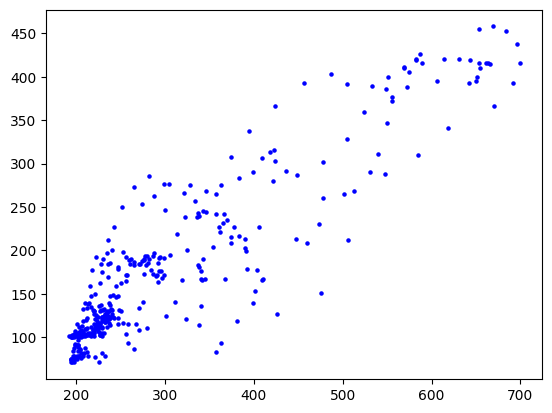

In [ ]:
#Visualizing the information of two arbitrary selected stations with arbitrary selected
#timeperiod for observing the connection between the water levels.
fig,ax = plt.subplots()
plot_data = data.loc[(data.index >= "2016-12-18") & (data.index <= "2017-12-24")]
y = plot_data["1724"].to_list()
y2 = plot_data["2275"].to_list()
ax.scatter(y, y2,s = 5,color="blue",marker="o")
plt.show()

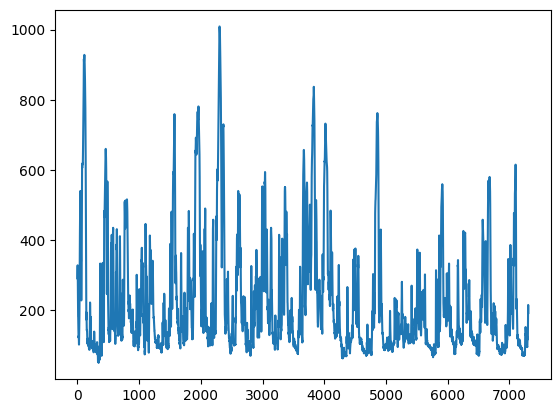

In [ ]:
#Plotting the water level for an arbitrary selected period of time for Szeged.
fig,ax = plt.subplots()
plot_data = data.loc[(data.index >= "2000-01-01") & (data.index <= "2020-01-01")]
y = plot_data["2275"].to_list()
x = np.linspace(1,len(y),len(y))
plt.plot(x,y)
plt.show()

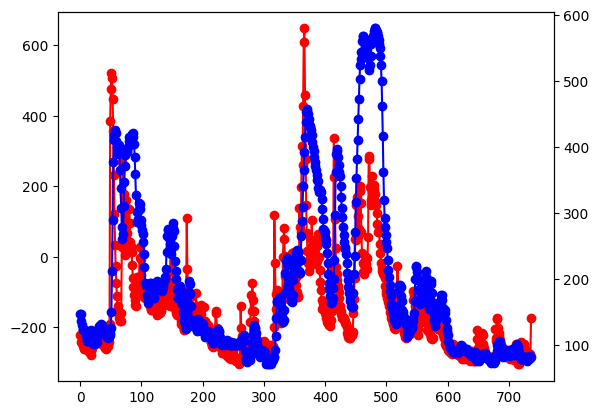

In [ ]:
#Visualizing the change of the water level for Szeged and an arbitrary selected station.
#Szeged follows the changes of the red station.
fig,ax = plt.subplots()
plot_data = data.loc[(data.index >= "2016-12-18") & (data.index <= "2018-12-24")]
y = plot_data["1515"].to_list()
ax.plot(y,color="red", marker="o")
ax2=ax.twinx()
y2 = plot_data["2275"].to_list()
ax2.plot(y2,color="blue",marker="o")
plt.show()

In [ ]:
#Donwloading meta data.csv file
!gdown --id 1MZ0bm8wAL8_qLGyq8DQzQd4xHLqD2lOH

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1MZ0bm8wAL8_qLGyq8DQzQd4xHLqD2lOH 



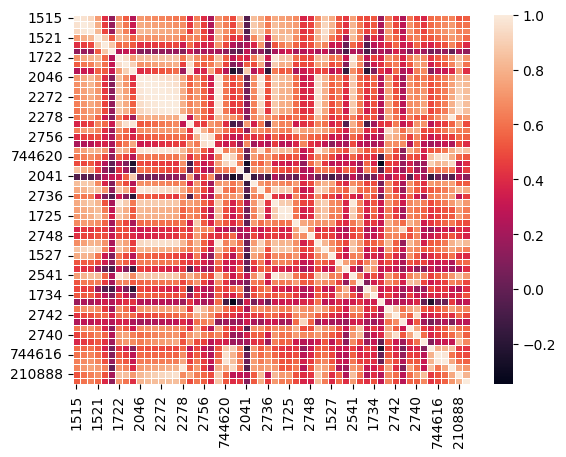

In [ ]:
#Correlation matrix between all the stations. Relatively high correlation can be found
#between all the stations.
correl = data.corr(method = "pearson")
sns.heatmap(correl,fmt=".2f", linewidth=.5)
plt.show()

Pytorch LSTM

In [ ]:
#Downloading the created training and validation files.
!gdown --id 1t2xlzVbw_Oc6pYrUk5ntQP55shUllgRK
!gdown --id 1xjTRjbiBVltExeSKePUyFrP-UvpJpbAb

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1t2xlzVbw_Oc6pYrUk5ntQP55shUllgRK
To: /content/data_training.csv
100% 7.13M/7.13M [00:00<00:00, 38.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xjTRjbiBVltExeSKePUyFrP-UvpJpbAb
To: /content/data_validation.csv
100% 1.71M/1.71M [00:00<00:00, 129MB/s]


In [ ]:
#Reading the files containing the preprocessed training and validation datas, including a split.
#The split makes sure that there is at least one flood in both dataset.
data_train = pd.read_csv("data_training.csv",index_col=0)
data_valid = pd.read_csv("data_validation.csv",index_col=0)
#Changing the data format of the index columns.
data_train.index = pd.to_datetime(data_train.index)
data_valid.index = pd.to_datetime(data_valid.index)
print("Stations: ",data_valid.columns)

Stations:  Index(['1515', '1516', '1518', '1521', '1719', '1720', '1722', '1723', '2040',
       '2046', '2048', '2271', '2272', '2274', '2275', '2278', '2543', '2753',
       '2756', '2757', '2760', '1514', '2041', '1523', '2042', '2736', '1721',
       '1724', '1725', '2744', '2748', '2759', '1520', '1527', '1729', '1726',
       '2541', '1530', '1732', '1734', '2049', '2741', '2742', '2751', '2545',
       '744624', '210888', '210900'],
      dtype='object')


In [ ]:
#This function requires the dataset, the number of days before the prediction and the number of the columns
#and gives back a torch tensor with a sliding window along time, selecting pastWindow size tensors.
def gen_X_tensor(dataset, pastWindow, colnum):
  windowed_data = np.lib.stride_tricks.sliding_window_view(dataset, (pastWindow,colnum)).reshape((-1,pastWindow,colnum))
  return torch.tensor(windowed_data, dtype = torch.float32)

#This function requires the dataset and the number of days, which needed to be predicted.
#Gives back the following windowSize days as the ground truth water level in Szeged.
def gen_y_tensor(dataset, windowSize):
  y_vals = []
  for i in range(len(dataset)-windowSize+1):
    days = []
    for j in range(windowSize):
      days.append(dataset["2275"].values[i+j])
    y_vals.append(days)
  return torch.reshape(torch.tensor(y_vals, dtype = torch.float32),(-1,windowSize))

In [ ]:
colnum = len(data_train.columns.tolist()) #Number of stations
pastWindow = 15 #Number of days before prediction
windowSize = 7 #Number of predicted days

#Creating the training/validation input datas. Because the predicted ground truth days
#should be from the training/validation datas as well, the last windowSize days cannot be
#included into the training/validation data.
X_train = gen_X_tensor(data_train[:-windowSize], pastWindow, colnum)
X_valid = gen_X_tensor(data_valid[:-windowSize], pastWindow, colnum)

LSTMnumpy = torch.Tensor(data_train.to_numpy()) #Tensor from pandas dataframe
means = LSTMnumpy.mean(axis=0, keepdims=True) #Mean of the training data
stds = LSTMnumpy.std(axis=0, keepdims=True) #Standard deviation of the training data
X_train = (X_train - means) / stds #Standardized training input
X_valid = (X_valid - means) / stds #Standardized validation input

#Generation of the ground truth output vectors, with windowSize. The first pastWindow size
#cannot be used, because there is not enough past size before that.
y_train = gen_y_tensor(data_train[pastWindow:],windowSize)
y_valid = gen_y_tensor(data_valid[pastWindow:],windowSize)
#Mean and Standard Deviation of Szeged.
y_mean = torch.full((1,7),means[0,14])
y_stds = torch.full((1,7),stds[0,14])
#Standardization of the training and validation datas.
y_train = (y_train - y_mean) / y_stds
y_valid = (y_valid - y_mean) / y_stds
#Check if the number of the input and output equal to each other.
print(f"Number of input: {len(X_train)}\t Number of output: {len(y_train)}")

Number of input: 19705	 Number of output: 19705


In [ ]:
#Inverse standardization of the datas.
def eval_back(y_vals, means, sdts):
  return y_vals*sdts+means

In [ ]:
#Creating the LSTM network
class HydroForecast(nn.Module):
    #definition of the layer types
    def __init__(self):
        super().__init__()
        #LSTM layers.
        self.lstm = nn.LSTM(input_size=colnum, hidden_size=10, num_layers=5, batch_first=True)
        #Linear layer at the end.
        self.linear = nn.Linear(10, 7)

    #creating the forward flow
    def forward(self, x):
        x, _ = self.lstm(x)
        # Extract only the last time step
        x = x[:, -1, :]
        x = self.linear(x)
        return x

#Manually setting a seed for random generators. This way the results can be reproduced.
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Assignment of the model.
model = HydroForecast()

In [ ]:
onnx.export(model, X_valid, 'iris.onnx', input_names=["staton information"], output_names=["predicted water level"])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
#Definition of loss function, by adding weights to stations in a way that:
#The closer the station is in time, the bigger the loss is.
def mylossW(output, target, weight):
  loss = torch.mean((torch.div(output - target,weight[:output.shape[0]]))**2)
  return loss

#Linear definition of the weigths. The weights according to these settings are linearly increasing numbers from 1 to the end of the predicted timeperiod.
w = []
for batch_iter in range(0,len(y_train)):
    wdays = []
    w.append(np.linspace(1,1,windowSize))
w =torch.Tensor(w)

<ipython-input-19-f118007eb277>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  w =torch.Tensor(w)


In [ ]:
def my_loss1(output, target, weight): #custom relu
  relu_breakpoint_Y = 0.4   #what weight all the small water-level datas get
  relu_breakpoint_X = 0.3   #where the weight-increasing starts

  loss = torch.mean((torch.div((output - target)*(        (target < relu_breakpoint_X) * relu_breakpoint_Y + (target >= relu_breakpoint_X) * (relu_breakpoint_Y + target - relu_breakingpoint_X)        ),weight[:output.shape[0]]))**2)
  return loss

In [ ]:
def my_loss2(output, target, weight): #custom relu squared
  relu_breakpoint_Y = 0.4   #what weight all the small water-level datas get
  relu_breakpoint_X = 0.3   #where the weight-increasing starts

  loss = torch.mean((torch.div((output - target)*(        (target < relu_breakpoint_X) * relu_breakpoint_Y + (target >= relu_breakpoint_X) * (relu_breakpoint_Y + target - relu_breakingpoint_X)**2        ),weight[:output.shape[0]]))**2)
  return loss

In [ ]:
def my_loss3(output, target, weight): #custom two section squared If[x < 0, -x^2/5 + 1, x^2 + 1]

  loss = torch.mean((torch.div((output - target)*(        (target < 0) *((target**2) * (-0.2) + 1) + (target >= 0) * (target**2 + 1)     ),weight[:output.shape[0]]))**2)
  return loss

In [ ]:
def my_loss4(output, target, weight): #custom staircase function
  starting_value = 0.5

  step1x = 0.2
  step1y = 0.7

  step2x = 0.5
  step2y = 1

  step3x = 0.8
  step3y = 1.5

  loss = torch.mean((torch.div((output - target)*(      (target < step1x)*starting_value + (step1x < target)*(target < step2x)*step1y + (step2x < target)*(target < step3x)*step2y + (step3x < target)*step3y          ),weight[:output.shape[0]]))**2)
  return loss

In [ ]:
#Transformation back from the standardized form of data.
def eval_back(y_vals, means, sdts):
  return y_vals*sdts+means

In [ ]:
import torch.optim as optim
import torch.utils.data as data

#Manually setting a seed for random generators. This way the results can be reproduced.
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Alias for myloss to specify which loss function should be used
my_loss = mylossW
#Define batchSize
batchSize = 8

#Adam optimizer creation.
optimizer = optim.Adam(model.parameters())
#Scheduler to reduce learnin rate on plateau.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

#Data loader
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batchSize)

n_epochs = 500 #Number of epochs
last_loss = 100 #Initial last_loss value for early stopping.
patience = 10 #Patience of early stopping
trigger_times = 0 #How many times was worse or result than before?

#Training
for epoch in range(n_epochs):
    model.train() #switch to train mode
    #For every batch, making prediction, calculating loss and then use optimizer.
    #This is the standard workflow of Pytorch.
    for X_batch, y_batch in loader: #Loading data in batches
        y_pred = model(X_batch) #make prediction
        loss = my_loss(y_pred, y_batch,w) #calculate loss
        optimizer.zero_grad() #zero the optimizer
        loss.backward() #calculate backpropogation
        optimizer.step() #make an optimization step
    model.eval() #switch evaluation mode
    with torch.inference_mode(): #inference_mode on
        #Loss of training and loss of validation is calculated here.
        #Standard workflow for validation
        y_pred = model(X_train) #make prediction in training
        train_rmse = np.sqrt(my_loss(y_pred, y_train,w)) #calculate loss
        y_pred = model(X_valid) #make prediction in validation
        valid_rmse = np.sqrt(my_loss(y_pred, y_valid,w)) #calculate loss
        print(f"Prediction: {eval_back(y_pred[1],y_mean,y_stds)}\nGround truth: {eval_back(y_valid[1],y_mean,y_stds)}")
    print("Epoch %d: train loss %.4f, validation loss %.4f" % (epoch, train_rmse, valid_rmse))
     # Early stopping
    current_loss = valid_rmse #Value of the current loss
    print('Current Loss: %.4f\t Last Loss: %.4f' % (current_loss,last_loss))

    #If current loss is worse or close to the current loss, trigger
    if last_loss-current_loss < 1e-5:
      trigger_times += 1
      print(f'Trigger Times: {trigger_times}')
    else:
      trigger_times = 0 #reset trigger

    #If the number of trigger times is larger of equal to patience number training over
    if trigger_times >= patience:
      print('Early stopping!\nStart to test process.')
      break
    print(f'trigger times: {trigger_times}')

    #Last loss equals to current loss
    last_loss = current_loss
    #Giving validation loss for the scheduler
    scheduler.step(valid_rmse)

Prediction: tensor([[230.3614, 213.9315, 196.0324, 181.0590, 171.6223, 172.9826, 176.6045]])
Ground truth: tensor([[215., 202., 192., 181., 170., 163., 161.]])
Epoch 0: train loss 0.1482, validation loss 0.1551
Current Loss: 0.1551	 Last Loss: 100.0000
trigger times: 0
Prediction: tensor([[228.0746, 211.9574, 195.5042, 181.7043, 172.2021, 170.4783, 171.1295]])
Ground truth: tensor([[215., 202., 192., 181., 170., 163., 161.]])
Epoch 1: train loss 0.1492, validation loss 0.1560
Current Loss: 0.1560	 Last Loss: 0.1551
Trigger Times: 1
trigger times: 1
Prediction: tensor([[223.3941, 205.6938, 188.2155, 174.9759, 168.5425, 170.6422, 175.0578]])
Ground truth: tensor([[215., 202., 192., 181., 170., 163., 161.]])
Epoch 2: train loss 0.1462, validation loss 0.1522
Current Loss: 0.1522	 Last Loss: 0.1560
trigger times: 0
Prediction: tensor([[232.6113, 217.2720, 200.9942, 186.8418, 176.4403, 173.0868, 171.9321]])
Ground truth: tensor([[215., 202., 192., 181., 170., 163., 161.]])
Epoch 3: train lo

In [ ]:
#Function for creating pandas dataframe with the predicted 7 days. This way the model can be observed out of this notebook as well.
def get_predictions(model):
    pred = pd.DataFrame(
        data=model(X_valid).detach().numpy(),
        index=data_valid[pastWindow-1:-windowSize].index,
        columns=["1day","2day","3day","4day","5day","6day","7day"])
    return pred

pred = get_predictions(model)

In [ ]:
import os
from google.colab import drive
#Mounting Colab to Google Drive.
drive.mount('/content/drive/')

#Creating directory for the models.
!mkdir -p "/content/drive/My Drive/ColabNotebooks/ECMI/Models"

#Created filename
fName = "LSTMmodel_s_loss3.csv"

#Saving prediction result file to the cloud computer.
pred.to_csv(fName, ',')

#Copy the created file to Drive.
!cp -r '/content/'+fName "/content/drive/My Drive/ColabNotebooks/ECMI/Models"

Mounted at /content/drive/
cp: cannot stat '/content/+fName': No such file or directory


In [ ]:
# Write standardization parameters to Google Drive
# Data Mean
with open('/content/drive/My Drive/ColabNotebooks/ECMI/Models/paramsMean.csv', 'w') as f:
  mlist = ["{}\n".format(i) for i in means[0]]
  f.writelines(mlist)
# Data Standard Deviation
with open('/content/drive/My Drive/ColabNotebooks/ECMI/Models/paramsSTDS.csv', 'w') as f:
  mlist = ["{}\n".format(i) for i in stds[0]]
  f.writelines(mlist)
# Mean only for Szeged to calculate in the case of Y values
with open('/content/drive/My Drive/ColabNotebooks/ECMI/Models/paramsYMean.csv', 'w') as f:
  mlist = ["{}\n".format(i) for i in y_mean[0]]
  f.writelines(mlist)
# Standard Deviation only for Szeged to calculate in the case of Y values
with open('/content/drive/My Drive/ColabNotebooks/ECMI/Models/paramsYSTDS.csv', 'w') as f:
  mlist = ["{}\n".format(i) for i in y_stds[0]]
  f.writelines(mlist)